In [17]:
import pandas as pd
import pickle
from imblearn.over_sampling import SMOTE, RandomOverSampler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plot
import numpy as npy
import xgboost as xgb
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.feature_selection import mutual_info_classif
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import (
    confusion_matrix, roc_auc_score, roc_curve, f1_score, precision_score, recall_score, accuracy_score
)

Let's do one hot encoding on the categorical features obtained after EDA Step 14 in Phase 1

In [18]:
# Remove 'other' gender, which has 3 data points

stroke_data = pd.read_csv("phase_1_preprocessed_data.csv", usecols=range(1,12))
worktype_onehot = pd.get_dummies(stroke_data['work_type'], prefix='work_type', dtype=int)
stroke_data = pd.concat([stroke_data, worktype_onehot], axis=1)
stroke_data = stroke_data.drop(['work_type'], axis=1)
stroke_data['ever_married'] = stroke_data['ever_married'].map({'yes': 1, 'no': 0})
stroke_data['smoking_status'] = stroke_data['smoking_status'].map({'is_or_was_smoker': 1, 'never_smoked': 0})
stroke_data['gender'] = stroke_data['gender'].map({'female': 1, 'male': 0})
stroke_data['bmi'] = stroke_data['bmi'].map({'healthy_bmi': 1, 'unhealthy_bmi': 0})
stroke_data['residence_type'] = stroke_data['residence_type'].map({'urban': 1, 'rural': 0})
stroke_data = stroke_data.dropna(subset=['gender'])
#Drop residence_type based on EDA Step 14
stroke_data = stroke_data.drop(['residence_type'], axis=1)
#stroke_data['avg_glucose_level'] = stroke_data['avg_glucose_level'].round()
#stroke_data['avg_glucose_level'] = (stroke_data['avg_glucose_level'] - stroke_data['avg_glucose_level'].min()) / (stroke_data['avg_glucose_level'].max() - stroke_data['avg_glucose_level'].min())
#stroke_data['age'] = (stroke_data['age'] - stroke_data['age'].min()) / (stroke_data['age'].max() - stroke_data['age'].min())


In [19]:
stroke_data.describe()

,gender,age,hypertension,heart_disease,ever_married,avg_glucose_level,bmi,smoking_status,stroke,work_type_govt_job,work_type_never_worked,work_type_private,work_type_self_employed
count,21107.000000,21107.000000,21107.000000,21107.00000,21107.000000,21107.000000,21107.000000,21107.000000,21107.000000,21107.000000,21107.000000,21107.000000,21107.000000
mean,0.603402,49.624058,0.109063,0.05908,0.776141,104.326449,0.297579,0.481641,0.023926,0.146634,0.001563,0.659213,0.192590
std,0.489203,18.275716,0.311726,0.23578,0.416839,43.041782,0.457204,0.499675,0.152821,0.353749,0.039511,0.473985,0.394343
min,0.000000,18.000000,0.000000,0.00000,0.000000,55.010000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,34.000000,0.000000,0.00000,1.000000,77.530000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,50.000000,0.000000,0.00000,1.000000,91.550000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,1.000000,64.000000,0.000000,0.00000,1.000000,111.775000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,1.000000,82.000000,1.000000,1.00000,1.000000,278.560000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Based upon EDA STEP 13, We need to handle the Imbalance in our Target 'stroke'.

In [20]:
X_input = stroke_data.drop(['stroke'], axis=1)
y_input = stroke_data['stroke']

# Split data into Train/Test Sets
X_train, X_test, y_train, y_test = train_test_split(X_input, y_input, test_size=0.15, random_state=30, stratify=y_input)
y_train.describe()

count    17940.000000
mean         0.023913
std          0.152783
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: stroke, dtype: float64

In [21]:
# Perform oversampling on the training set only
oversample_random = RandomOverSampler(sampling_strategy='minority')
X_train_oversampled_ro, y_train_ro = oversample_random.fit_resample(X_train, y_train)
scaler_ro = RobustScaler()
X_train_ro = scaler_ro.fit_transform(X_train_oversampled_ro)
X_test_ro = scaler_ro.transform(X_test)
print('Class dist. before resampling:\n', y_train.value_counts())
print('Class dist. after  resampling:\n', y_train_ro.value_counts())
with open("scaler.pkl", "wb") as file:
    pickle.dump(scaler_ro, file)
X_train_oversampled_ro.describe()

Class dist. before resampling:
 stroke
0    17511
1      429
Name: count, dtype: int64
Class dist. after  resampling:
 stroke
0    17511
1    17511
Name: count, dtype: int64


,gender,age,hypertension,heart_disease,ever_married,avg_glucose_level,bmi,smoking_status,work_type_govt_job,work_type_never_worked,work_type_private,work_type_self_employed
count,35022.000000,35022.000000,35022.000000,35022.000000,35022.000000,35022.000000,35022.000000,35022.000000,35022.000000,35022.000000,35022.000000,35022.000000
mean,0.577066,58.881246,0.174033,0.139798,0.841500,113.981589,0.256439,0.526441,0.129975,0.000771,0.617041,0.252213
std,0.494032,18.224894,0.379144,0.346782,0.365215,51.247551,0.436673,0.499308,0.336281,0.027756,0.486115,0.434289
min,0.000000,18.000000,0.000000,0.000000,0.000000,55.010000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,46.000000,0.000000,0.000000,1.000000,78.120000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,62.000000,0.000000,0.000000,1.000000,94.630000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000
75%,1.000000,76.000000,0.000000,0.000000,1.000000,130.550000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000
max,1.000000,82.000000,1.000000,1.000000,1.000000,278.560000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [22]:
X_test_ro

array([[-1.        ,  0.43333333,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-1.        , -0.43333333,  1.        , ...,  0.        ,
         0.        ,  0.        ],
       [-1.        , -1.26666667,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.        , -0.96666667,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-1.        , -0.6       ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

In [23]:
# Perform oversampling on the training set only
oversample_smote = SMOTE(random_state=61)
X_train_resampled_smote, y_train_smote = oversample_smote.fit_resample(X_train, y_train)
scaler = StandardScaler()
X_train_smote = scaler.fit_transform(X_train_resampled_smote)
X_test_smote = scaler.transform(X_test)
print('Class dist. before resampling:\n', y_train.value_counts())
print('Class dist. after  resampling:\n', y_train_smote.value_counts())

Class dist. before resampling:
 stroke
0    17511
1      429
Name: count, dtype: int64
Class dist. after  resampling:
 stroke
0    17511
1    17511
Name: count, dtype: int64


# Logistic Regression

Fitting 5 folds for each of 200 candidates, totalling 1000 fits
[CV] END C=0.001, l1_ratio=0.0, max_iter=10000, penalty=elasticnet, solver=saga; total time=   0.0s
[CV] END C=0.001, l1_ratio=0.0, max_iter=10000, penalty=elasticnet, solver=saga; total time=   0.0s
[CV] END C=0.001, l1_ratio=0.0, max_iter=10000, penalty=elasticnet, solver=saga; total time=   0.0s
[CV] END C=0.001, l1_ratio=0.0, max_iter=10000, penalty=elasticnet, solver=saga; total time=   0.0s
[CV] END C=0.001, l1_ratio=0.0, max_iter=10000, penalty=elasticnet, solver=saga; total time=   0.0s
[CV] END C=0.001, l1_ratio=0.1111111111111111, max_iter=10000, penalty=elasticnet, solver=saga; total time=   0.0s
[CV] END C=0.001, l1_ratio=0.1111111111111111, max_iter=10000, penalty=elasticnet, solver=saga; total time=   0.0s
[CV] END C=0.001, l1_ratio=0.1111111111111111, max_iter=10000, penalty=elasticnet, solver=saga; total time=   0.0s
[CV] END C=0.001, l1_ratio=0.1111111111111111, max_iter=10000, penalty=elasticnet, solver=s

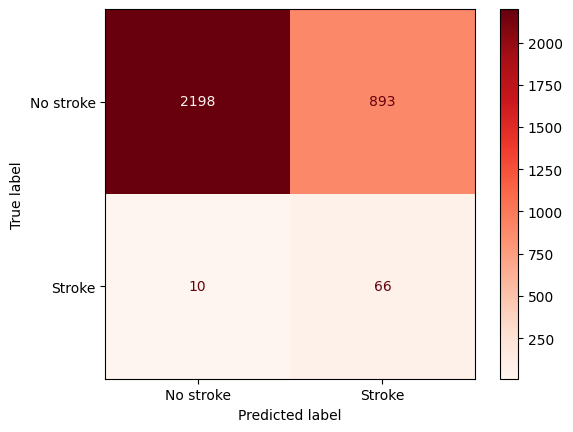

ROC-AUC Score: 0.8527814197415248


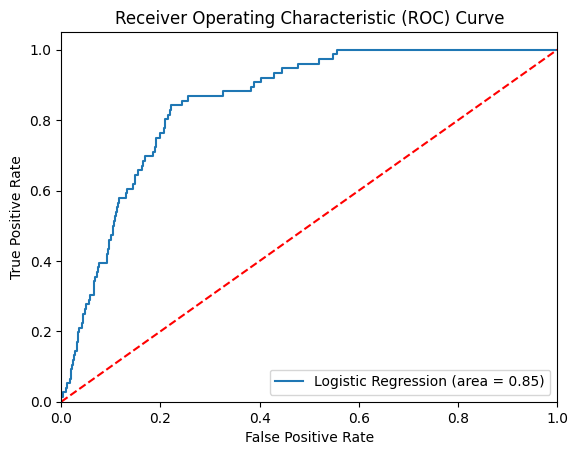

In [24]:
# Define hyperparameters and their possible values
param_grid = {
    'C': npy.logspace(-3, 1, 20),
    'penalty': ['elasticnet'],
    'solver': ['saga'],  # Use 'saga' solver as it supports all penalty options
    'l1_ratio': npy.linspace(0, 1, 10),  # Include l1_ratio values only when using 'elasticnet' penalty
    'max_iter': [10000]
}

# Create a LogisticRegression estimator
logreg_RO = LogisticRegression(class_weight='balanced', random_state=16)

# Use Grid Search to get the best Hyper parameters
grid_search = GridSearchCV(logreg_RO, param_grid, scoring='roc_auc', cv=5, verbose=2)

# Fit the model
grid_search.fit(X_train_ro, y_train_ro)
best_logreg = grid_search.best_estimator_

y_pred = best_logreg.predict(X_test_ro)
y_pred_proba = best_logreg.predict_proba(X_test_ro)[:, 1]

cm = confusion_matrix(y_test, y_pred)
class_names = ['No stroke', 'Stroke']
ConfusionMatrixDisplay.from_estimator(best_logreg, X_test_ro, y_test, cmap=plot.cm.Reds, display_labels=class_names)
plot.show()

roc_auc = roc_auc_score(y_test, y_pred_proba)
print('ROC-AUC Score:', roc_auc)

fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

plot.figure()
plot.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % roc_auc)
plot.plot([0, 1], [0, 1], 'r--')
plot.xlim([0.0, 1.0])
plot.ylim([0.0, 1.05])
plot.xlabel('False Positive Rate')
plot.ylabel('True Positive Rate')
plot.title('Receiver Operating Characteristic (ROC) Curve')
plot.legend(loc="lower right")
plot.show()

In [25]:
print("Logistic Regression Classification Report:\n", classification_report(y_test, y_pred))

Logistic Regression Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.71      0.83      3091
           1       0.07      0.87      0.13        76

    accuracy                           0.71      3167
   macro avg       0.53      0.79      0.48      3167
weighted avg       0.97      0.71      0.81      3167



In [30]:
# Feature importance
print("Feature Importance RO + LOG REG\n")
f_imp = pd.DataFrame(columns = ['feature', 'importance_coef'], index = range(12))
for i in range(len(f_imp.index)):
    f_imp.iloc[i, 0] = X_train.columns.to_list()[i]
f_imp['importance_coef'] = abs(best_logreg.coef_)[0]
f_imp = f_imp.sort_values('importance_coef', ascending = False)
f_imp[0:12].style.background_gradient(cmap = 'Reds')

Feature Importance RO + LOG REG



,feature,importance_coef
9,work_type_never_worked,3.059315
1,age,2.120940
3,heart_disease,0.574153
6,bmi,0.338633
2,hypertension,0.316744
7,smoking_status,0.305618
5,avg_glucose_level,0.167911
10,work_type_private,0.107787
11,work_type_self_employed,0.083708
0,gender,0.025097


In [31]:
best_params = grid_search.best_params_
best_params

{'C': 6.158482110660261,
 'l1_ratio': 1.0,
 'max_iter': 10000,
 'penalty': 'elasticnet',
 'solver': 'saga'}

In [58]:
# Identify the Optimal Threshold For Classification
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# Calculate the optimal threshold using the Youden's J statistic
optimal_idx = npy.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print("Optimal threshold:", optimal_threshold)

# Use the optimal threshold for classification
y_pred_custom = npy.where(y_pred_proba > optimal_threshold, 1, 0)


Optimal threshold: 0.5837065995154248


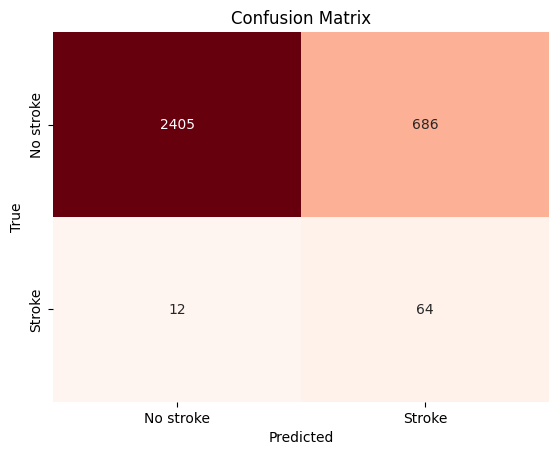

Logistic Regression Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.78      0.87      3091
           1       0.09      0.84      0.15        76

    accuracy                           0.78      3167
   macro avg       0.54      0.81      0.51      3167
weighted avg       0.97      0.78      0.86      3167



In [59]:
import seaborn as sea_b
# Set a custom threshold
custom_threshold = 0.5837065995154248

# Get predicted probabilities
y_pred_proba = best_logreg.predict_proba(X_test_ro)[:, 1]

# Apply the custom threshold
y_pred_custom_threshold = (y_pred_proba >= custom_threshold).astype(int)

# Create the confusion matrix using the custom threshold
cm = confusion_matrix(y_test, y_pred_custom_threshold)

# Plot the confusion matrix
fig, ax = plot.subplots()
sea_b.heatmap(cm, annot=True, fmt='d', cmap=plot.cm.Reds, cbar=False, ax=ax)
ax.set_xlabel('Predicted')
ax.set_ylabel('True')
ax.set_xticklabels(class_names)
ax.set_yticklabels(class_names)
plot.title('Confusion Matrix')
plot.show()
print("Logistic Regression Classification Report:\n", classification_report(y_test, y_pred_custom_threshold))

In [14]:
# Save the best model to a file
with open("model.pkl", "wb") as file:
    pickle.dump(best_logreg, file)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits
[CV] END C=0.001, l1_ratio=0.0, max_iter=10000, penalty=elasticnet, solver=saga; total time=   0.0s
[CV] END C=0.001, l1_ratio=0.0, max_iter=10000, penalty=elasticnet, solver=saga; total time=   0.0s
[CV] END C=0.001, l1_ratio=0.0, max_iter=10000, penalty=elasticnet, solver=saga; total time=   0.0s
[CV] END C=0.001, l1_ratio=0.0, max_iter=10000, penalty=elasticnet, solver=saga; total time=   0.0s
[CV] END C=0.001, l1_ratio=0.0, max_iter=10000, penalty=elasticnet, solver=saga; total time=   0.0s
[CV] END C=0.001, l1_ratio=0.1111111111111111, max_iter=10000, penalty=elasticnet, solver=saga; total time=   0.0s
[CV] END C=0.001, l1_ratio=0.1111111111111111, max_iter=10000, penalty=elasticnet, solver=saga; total time=   0.0s
[CV] END C=0.001, l1_ratio=0.1111111111111111, max_iter=10000, penalty=elasticnet, solver=saga; total time=   0.0s
[CV] END C=0.001, l1_ratio=0.1111111111111111, max_iter=10000, penalty=elasticnet, solver=s

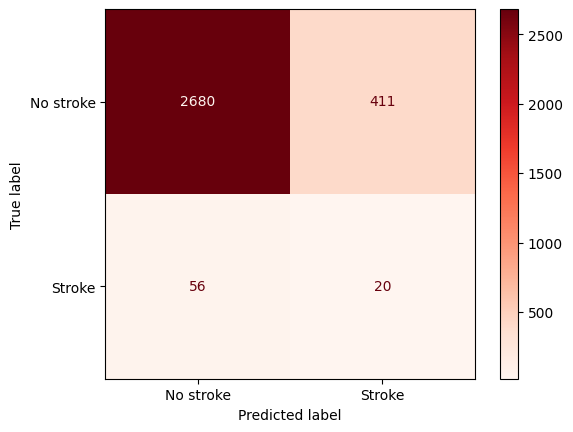

ROC-AUC Score: 0.7165582591224098


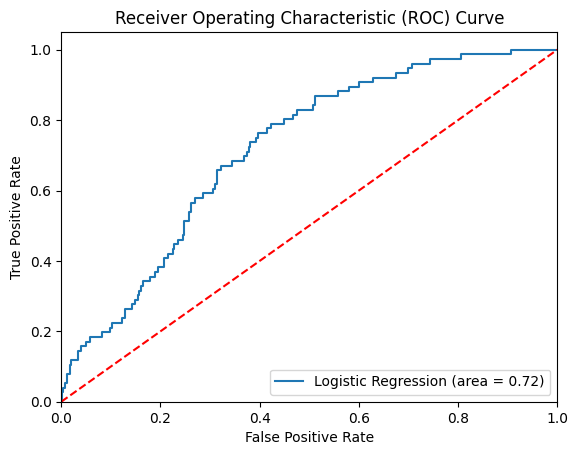

Logistic Regression Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.87      0.92      3091
           1       0.05      0.26      0.08        76

    accuracy                           0.85      3167
   macro avg       0.51      0.57      0.50      3167
weighted avg       0.96      0.85      0.90      3167

Feature Importance RO + LOG REG



,feature,importance_coef
10,work_type_private,2.994696
11,work_type_self_employed,2.380281
8,work_type_govt_job,2.043159
1,age,1.541349
6,bmi,0.696186
2,hypertension,0.395822
9,work_type_never_worked,0.262904
4,ever_married,0.235178
7,smoking_status,0.200734
3,heart_disease,0.157776


In [15]:
# Define hyperparameters and their possible values
param_grid = {
    'C': npy.logspace(-3, 1, 20),
    'penalty': ['elasticnet'],
    'solver': ['saga'],  # Use 'saga' solver as it supports all penalty options
    'l1_ratio': npy.linspace(0, 1, 10),  # Include l1_ratio values only when using 'elasticnet' penalty
    'max_iter': [10000]
}

# Create a LogisticRegression estimator
logreg_SMOTE = LogisticRegression()

# Use Grid Search to get the best Hyper parameters
grid_search = GridSearchCV(logreg_SMOTE, param_grid, scoring='roc_auc', cv=5, verbose=2)

# Fit the model
grid_search.fit(X_train_smote, y_train_smote)
best_logreg_smote = grid_search.best_estimator_

y_pred = best_logreg_smote.predict(X_test_smote)
y_pred_proba = best_logreg_smote.predict_proba(X_test_smote)[:, 1]

cm = confusion_matrix(y_test, y_pred)
class_names = ['No stroke', 'Stroke']
ConfusionMatrixDisplay.from_estimator(best_logreg_smote, X_test_smote, y_test, cmap=plot.cm.Reds, display_labels=class_names)
plot.show()

roc_auc = roc_auc_score(y_test, y_pred_proba)
print('ROC-AUC Score:', roc_auc)

fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

plot.figure()
plot.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % roc_auc)
plot.plot([0, 1], [0, 1], 'r--')
plot.xlim([0.0, 1.0])
plot.ylim([0.0, 1.05])
plot.xlabel('False Positive Rate')
plot.ylabel('True Positive Rate')
plot.title('Receiver Operating Characteristic (ROC) Curve')
plot.legend(loc="lower right")
plot.show()
print("Logistic Regression Classification Report:\n", classification_report(y_test, y_pred))
# Feature importance
print("Feature Importance RO + LOG REG\n")
f_imp = pd.DataFrame(columns = ['feature', 'importance_coef'], index = range(12))
for i in range(len(f_imp.index)):
    f_imp.iloc[i, 0] = X_train.columns.to_list()[i]
f_imp['importance_coef'] = abs(best_logreg_smote.coef_)[0]
f_imp = f_imp.sort_values('importance_coef', ascending = False)
f_imp[0:12].style.background_gradient(cmap = 'Reds')

# Using K-NN

In [365]:
from sklearn.neighbors import KNeighborsClassifier
k_range = list(range(1, 16))
param_grid = {'n_neighbors': k_range}
knn_RO = KNeighborsClassifier()
grid = GridSearchCV(knn_RO, param_grid, cv=10, scoring='accuracy', return_train_score=False, verbose=2)
grid.fit(X_train_ro, y_train_ro)

Fitting 10 folds for each of 15 candidates, totalling 150 fits
[CV] END ......................................n_neighbors=1; total time=   0.2s
[CV] END ......................................n_neighbors=1; total time=   0.2s
[CV] END ......................................n_neighbors=1; total time=   0.1s
[CV] END ......................................n_neighbors=1; total time=   0.2s
[CV] END ......................................n_neighbors=1; total time=   0.2s
[CV] END ......................................n_neighbors=1; total time=   0.1s
[CV] END ......................................n_neighbors=1; total time=   0.1s
[CV] END ......................................n_neighbors=1; total time=   0.2s
[CV] END ......................................n_neighbors=1; total time=   0.2s
[CV] END ......................................n_neighbors=1; total time=   0.2s
[CV] END ......................................n_neighbors=2; total time=   0.2s
[CV] END .....................................

GridSearchCV(cv=10, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                         13, 14, 15]},
             scoring='accuracy', verbose=2)

In [366]:
best_params = grid.best_params_
best_knn_RO = KNeighborsClassifier(**best_params)
best_knn_RO.fit(X_train_ro, y_train_ro)
best_knn_RO

KNeighborsClassifier(n_neighbors=1)

ROC-AUC Score: 0.5321412760305811


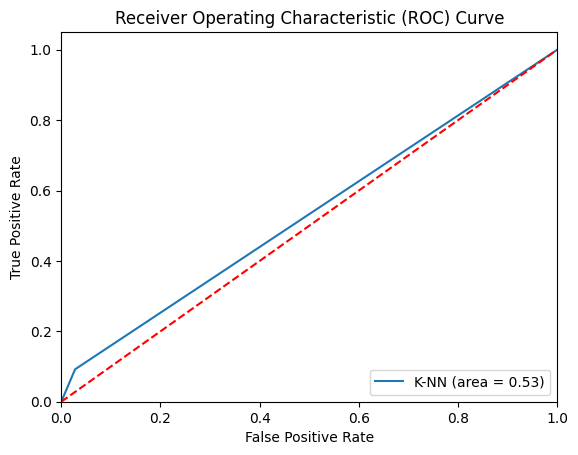

In [367]:
y_pred = best_knn_RO.predict(X_test_ro)
y_pred_prob = best_knn_RO.predict_proba(X_test_ro)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

roc_auc = roc_auc_score(y_test, y_pred_prob)
print("ROC-AUC Score:", roc_auc)

plot.figure()
plot.plot(fpr, tpr, label='K-NN (area = %0.2f)' % roc_auc)
plot.plot([0, 1], [0, 1], 'r--')
plot.xlim([0.0, 1.0])
plot.ylim([0.0, 1.05])
plot.xlabel('False Positive Rate')
plot.ylabel('True Positive Rate')
plot.title('Receiver Operating Characteristic (ROC) Curve')
plot.legend(loc="lower right")
plot.show()

In [368]:
print("KNN + RO Classification Report:\n", classification_report(y_test, y_pred))

KNN + RO Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.97      0.97      3091
           1       0.08      0.09      0.08        76

    accuracy                           0.95      3167
   macro avg       0.53      0.53      0.53      3167
weighted avg       0.96      0.95      0.95      3167



C:\Users\roysu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.7_qbz5n2kfra8p0\LocalCache\local-packages\Python37\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


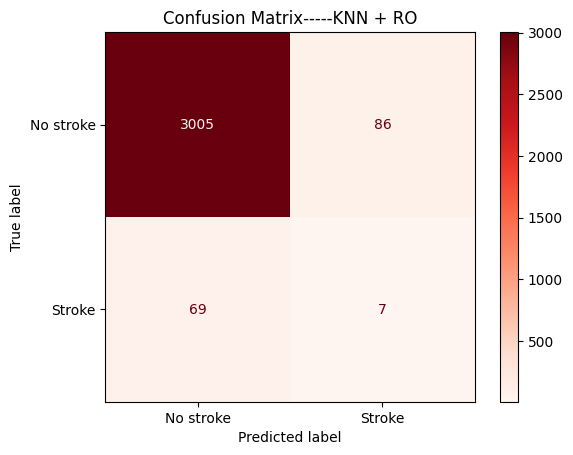

In [369]:
class_names = ['No stroke', 'Stroke']
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay.from_estimator(best_knn_RO, X_test_ro, y_test, cmap=plot.cm.Reds, display_labels=class_names)
disp.ax_.set_title("Confusion Matrix-----KNN + RO")
plot.show()

In [370]:
from sklearn.inspection import permutation_importance

# Compute permutation importances
result = permutation_importance(best_knn_RO, X_test_ro, y_test, n_repeats=10, random_state=42)
feature_importances = result.importances_mean
feature_names = ['gender', 'age', 'hypertension', 'heart_disease', 'ever_married', 'avg_glucose_level', 'bmi', 'smoking_status', 'work_type_govt_job', 'work_type_never_worked', 'work_type_private', 'work_type_self_employed']
normalized_importances = feature_importances / npy.sum(feature_importances)
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': normalized_importances})
importance_df = importance_df.sort_values('Importance', ascending = False)
importance_df.set_index('Feature').style.background_gradient(cmap='Reds')

,Importance
Feature,
age,0.279029
avg_glucose_level,0.162912
bmi,0.159445
heart_disease,0.154246
smoking_status,0.124783
work_type_govt_job,0.086655
work_type_self_employed,0.055459
gender,0.029463
work_type_never_worked,0.001733


KNN + SMOTE

In [371]:
k_range = list(range(1, 16))
param_grid = {'n_neighbors': k_range}
knn_SMOTE = KNeighborsClassifier()
grid = GridSearchCV(knn_SMOTE, param_grid, cv=15, scoring='accuracy', return_train_score=False, verbose=2)
grid.fit(X_train_smote, y_train_smote)
best_params = grid.best_params_
best_knn_SMOTE = KNeighborsClassifier(**best_params)
best_knn_SMOTE.fit(X_train_smote, y_train_smote)
best_knn_SMOTE

Fitting 15 folds for each of 15 candidates, totalling 225 fits
[CV] END ......................................n_neighbors=1; total time=   0.1s
[CV] END ......................................n_neighbors=1; total time=   0.1s
[CV] END ......................................n_neighbors=1; total time=   0.1s
[CV] END ......................................n_neighbors=1; total time=   0.1s
[CV] END ......................................n_neighbors=1; total time=   0.1s
[CV] END ......................................n_neighbors=1; total time=   0.1s
[CV] END ......................................n_neighbors=1; total time=   0.1s
[CV] END ......................................n_neighbors=1; total time=   0.1s
[CV] END ......................................n_neighbors=1; total time=   0.1s
[CV] END ......................................n_neighbors=1; total time=   0.1s
[CV] END ......................................n_neighbors=1; total time=   0.1s
[CV] END .....................................

KNeighborsClassifier(n_neighbors=1)

ROC-AUC Score: 0.6028984828619592


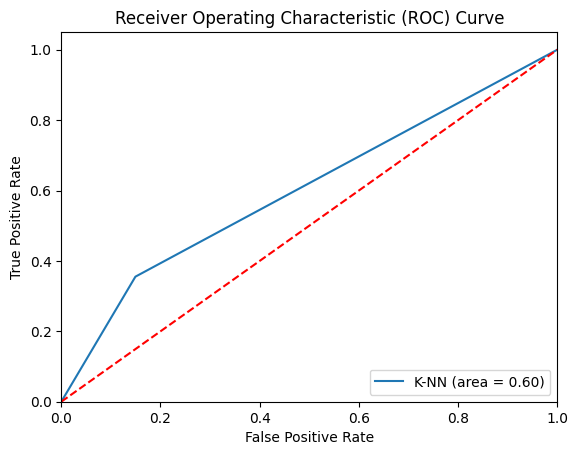

KNN Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.85      0.91      3091
           1       0.06      0.36      0.10        76

    accuracy                           0.84      3167
   macro avg       0.52      0.60      0.50      3167
weighted avg       0.96      0.84      0.89      3167



C:\Users\roysu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.7_qbz5n2kfra8p0\LocalCache\local-packages\Python37\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


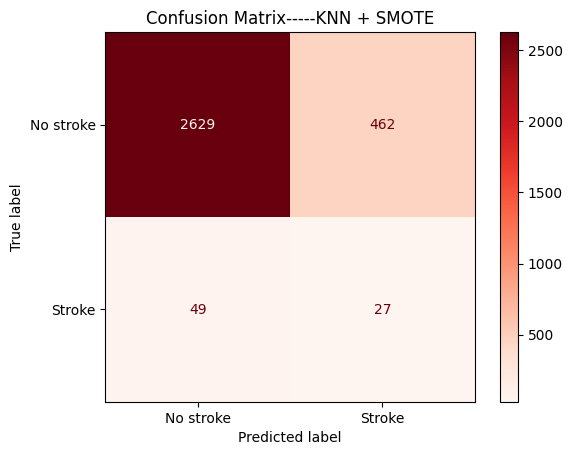

KNN + SMOTE Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.85      0.91      3091
           1       0.06      0.36      0.10        76

    accuracy                           0.84      3167
   macro avg       0.52      0.60      0.50      3167
weighted avg       0.96      0.84      0.89      3167



In [372]:
y_pred = best_knn_SMOTE.predict(X_test_smote)
y_pred_prob = best_knn_SMOTE.predict_proba(X_test_smote)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

roc_auc = roc_auc_score(y_test, y_pred_prob)
print("ROC-AUC Score:", roc_auc)

plot.figure()
plot.plot(fpr, tpr, label='K-NN (area = %0.2f)' % roc_auc)
plot.plot([0, 1], [0, 1], 'r--')
plot.xlim([0.0, 1.0])
plot.ylim([0.0, 1.05])
plot.xlabel('False Positive Rate')
plot.ylabel('True Positive Rate')
plot.title('Receiver Operating Characteristic (ROC) Curve')
plot.legend(loc="lower right")
plot.show()
print("KNN Classification Report:\n", classification_report(y_test, y_pred))
class_names = ['No stroke', 'Stroke']
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay.from_estimator(best_knn_SMOTE, X_test_smote, y_test, cmap=plot.cm.Reds, display_labels=class_names)
disp.ax_.set_title("Confusion Matrix-----KNN + SMOTE")
plot.show()
# Compute permutation importances
result = permutation_importance(best_knn_SMOTE, X_test_smote, y_test, n_repeats=10, random_state=42)
feature_importances = result.importances_mean
feature_names = ['gender', 'age', 'hypertension', 'heart_disease', 'ever_married', 'avg_glucose_level', 'bmi', 'smoking_status', 'work_type_govt_job', 'work_type_never_worked', 'work_type_private', 'work_type_self_employed']
normalized_importances = feature_importances / npy.sum(feature_importances)
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': normalized_importances})
importance_df = importance_df.sort_values('Importance', ascending = False)
importance_df.set_index('Feature').style.background_gradient(cmap='Reds')
print("KNN + SMOTE Classification Report:\n", classification_report(y_test, y_pred))

# Using Naive Bayes

In [373]:
print("Mutual Info Score --- Random Oversampling\n")
mutual_info_ro = mutual_info_classif(X_test_ro, y_test)
feature_names = ['gender', 'age', 'hypertension', 'heart_disease', 'ever_married', 'avg_glucose_level', 'bmi', 'smoking_status', 'work_type_govt_job', 'work_type_never_worked', 'work_type_private', 'work_type_self_employed']
mi_df = pd.DataFrame({'Feature': feature_names, 'Mutual Information': mutual_info_ro})
sorted_mi_df = mi_df.sort_values(by='Mutual Information', ascending=False)
sorted_mi_df.set_index('Feature').style.background_gradient(cmap='Reds')


Mutual Info Score --- Random Oversampling



,Mutual Information
Feature,
age,0.020343
hypertension,0.011788
avg_glucose_level,0.005115
heart_disease,0.003136
work_type_self_employed,0.002246
ever_married,0.002219
bmi,0.001655
work_type_govt_job,0.001386
work_type_private,0.000743


In [375]:
param_grid = {'var_smoothing': npy.logspace(-10, -1, num=100)}
gnb = GaussianNB()
grid = GridSearchCV(gnb, param_grid, cv=15, scoring='accuracy', return_train_score=False)
grid.fit(X_train_ro, y_train_ro)
best_params_ro = grid.best_params_
best_gnb_ro = GaussianNB(**best_params_ro)
best_gnb_ro.fit(X_train_ro, y_train_ro)
y_pred = best_gnb_ro.predict(X_test_ro)
y_pred_prob = best_gnb_ro.predict_proba(X_test_ro)[:, 1]

In [376]:
best_gnb_ro

GaussianNB(var_smoothing=0.1)

ROC-AUC Score: 0.8300158354475643


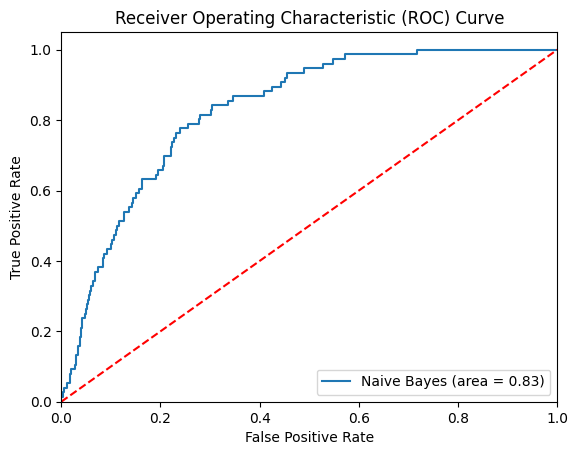

In [377]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = roc_auc_score(y_test, y_pred_prob)
print("ROC-AUC Score:", roc_auc)
plot.figure()
plot.plot(fpr, tpr, label='Naive Bayes (area = %0.2f)' % roc_auc)
plot.plot([0, 1], [0, 1], 'r--')
plot.xlim([0.0, 1.0])
plot.ylim([0.0, 1.05])
plot.xlabel('False Positive Rate')
plot.ylabel('True Positive Rate')
plot.title('Receiver Operating Characteristic (ROC) Curve')
plot.legend(loc="lower right")
plot.show()

In [378]:
print("Naive Bayes + RO Classification Report:\n", classification_report(y_test, y_pred))

Naive Bayes + RO Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.55      0.71      3091
           1       0.05      0.92      0.09        76

    accuracy                           0.56      3167
   macro avg       0.52      0.73      0.40      3167
weighted avg       0.97      0.56      0.69      3167



C:\Users\roysu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.7_qbz5n2kfra8p0\LocalCache\local-packages\Python37\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


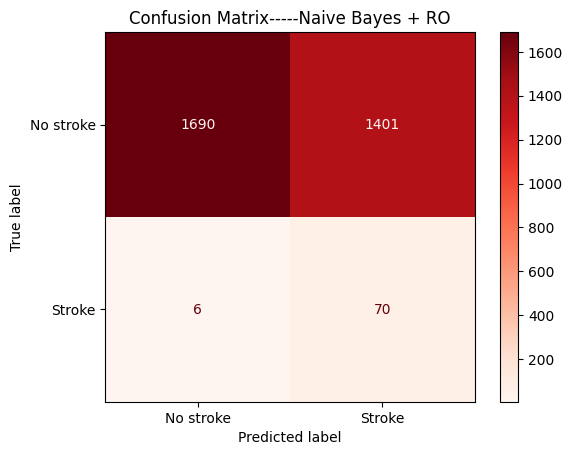

In [379]:
class_names = ['No stroke', 'Stroke']
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay.from_estimator(best_gnb_ro, X_test_ro, y_test, cmap=plot.cm.Reds, display_labels=class_names)
disp.ax_.set_title("Confusion Matrix-----Naive Bayes + RO")
plot.show()

In [ ]:
print(y_pred)
print(y_pred_prob) # array of predicted probabilities for the positive class for each input feature in X_test

GNB + SMOTE

In [380]:
mutual_info_smote = mutual_info_classif(X_test_smote, y_test)
feature_names = ['gender', 'age', 'hypertension', 'heart_disease', 'ever_married', 'avg_glucose_level', 'bmi', 'smoking_status', 'work_type_govt_job', 'work_type_never_worked', 'work_type_private', 'work_type_self_employed']
mi_df = pd.DataFrame({'Feature': feature_names, 'Mutual Information': mutual_info_smote})
sorted_mi_df = mi_df.sort_values(by='Mutual Information', ascending=False)
sorted_mi_df.set_index('Feature').style.background_gradient(cmap='Reds')
print("Mutual Info Score --- SMOTE Oversampling\n")

param_grid = {'var_smoothing': npy.logspace(-10, -1, num=100)}
gnb_smote = GaussianNB()
grid = GridSearchCV(gnb_smote, param_grid, cv=15, scoring='accuracy', return_train_score=False)
grid.fit(X_train_smote, y_train_smote)
best_params_ro = grid.best_params_
best_gnb_smote = GaussianNB(**best_params_ro)
best_gnb_smote.fit(X_train_smote, y_train_smote)
y_pred = best_gnb_smote.predict(X_test_smote)
y_pred_prob = best_gnb_smote.predict_proba(X_test_smote)[:, 1]
best_gnb_smote

Mutual Info Score --- SMOTE Oversampling



GaussianNB(var_smoothing=0.1)

In [395]:
sorted_mi_df.set_index('Feature').style.background_gradient(cmap='Reds')

,Mutual Information
Feature,
age,0.025099
hypertension,0.008686
ever_married,0.005714
avg_glucose_level,0.005251
smoking_status,0.004668
work_type_private,0.002835
bmi,0.002508
work_type_self_employed,0.002146
heart_disease,0.001741


ROC-AUC Score: 0.8287728379505866


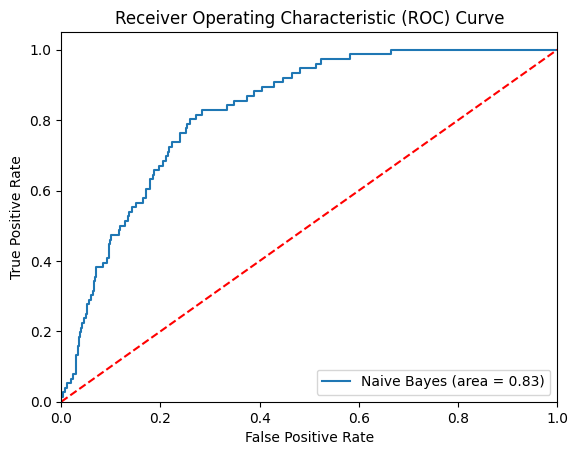

Naive Bayes + SMOTE Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.54      0.70      3091
           1       0.05      0.92      0.09        76

    accuracy                           0.55      3167
   macro avg       0.52      0.73      0.40      3167
weighted avg       0.97      0.55      0.69      3167



C:\Users\roysu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.7_qbz5n2kfra8p0\LocalCache\local-packages\Python37\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


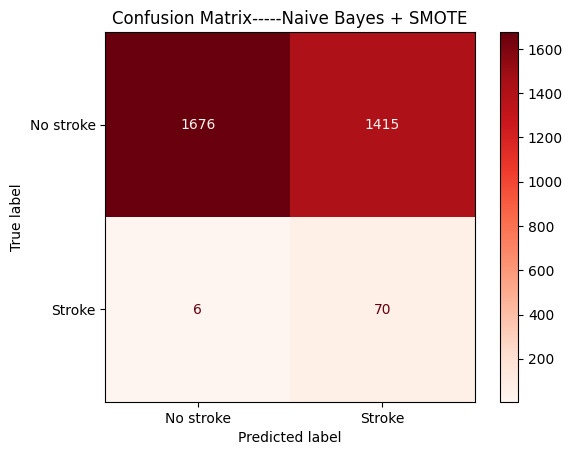

In [381]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = roc_auc_score(y_test, y_pred_prob)
print("ROC-AUC Score:", roc_auc)
plot.figure()
plot.plot(fpr, tpr, label='Naive Bayes (area = %0.2f)' % roc_auc)
plot.plot([0, 1], [0, 1], 'r--')
plot.xlim([0.0, 1.0])
plot.ylim([0.0, 1.05])
plot.xlabel('False Positive Rate')
plot.ylabel('True Positive Rate')
plot.title('Receiver Operating Characteristic (ROC) Curve')
plot.legend(loc="lower right")
plot.show()
print("Naive Bayes + SMOTE Classification Report:\n", classification_report(y_test, y_pred))
class_names = ['No stroke', 'Stroke']
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay.from_estimator(best_gnb_smote, X_test_smote, y_test, cmap=plot.cm.Reds, display_labels=class_names)
disp.ax_.set_title("Confusion Matrix-----Naive Bayes + SMOTE")
plot.show()

# Decision Tree

In [399]:
param_grid = {
    "criterion": ["gini", "entropy"],
    "max_depth": [None, 2, 4, 6, 8, 10],
    "min_samples_split": [20, 50, 100],
    "min_samples_leaf": [1, 5]
}

dtc = DecisionTreeClassifier()
grid_search = GridSearchCV(dtc, param_grid, scoring='roc_auc', cv=15)
grid_search.fit(X_train_ro, y_train_ro)

best_params = grid_search.best_params_
print("Best parameters found:", best_params)

dtc_best = DecisionTreeClassifier(**best_params)
dtc_best.fit(X_train_ro, y_train_ro)

y_pred = dtc_best.predict(X_test_ro)
y_pred_proba = dtc_best.predict_proba(X_test_ro)[:, 1]

Best parameters found: {'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 20}


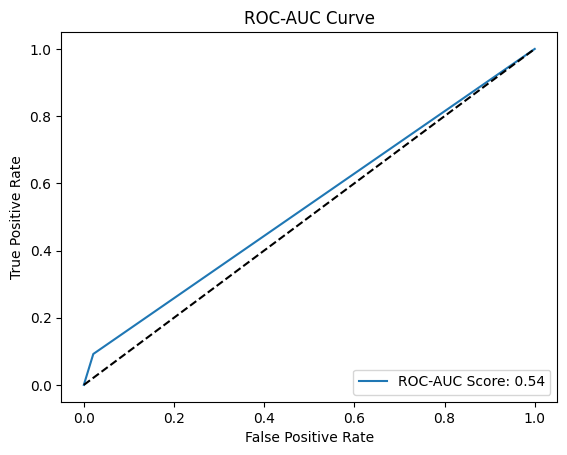

Decision Tree + RO Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.98      0.98      3091
           1       0.10      0.09      0.09        76

    accuracy                           0.96      3167
   macro avg       0.54      0.54      0.54      3167
weighted avg       0.96      0.96      0.96      3167



In [400]:
# Plot ROC-AUC curve
roc_auc = roc_auc_score(y_test, y_pred_proba)
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plot.plot(fpr, tpr, label=f"ROC-AUC Score: {roc_auc:.2f}")
plot.plot([0, 1], [0, 1], 'k--')
plot.xlabel('False Positive Rate')
plot.ylabel('True Positive Rate')
plot.title('ROC-AUC Curve')
plot.legend(loc="lower right")
plot.show()
print("Decision Tree + RO Classification Report:\n", classification_report(y_test, y_pred))


C:\Users\roysu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.7_qbz5n2kfra8p0\LocalCache\local-packages\Python37\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


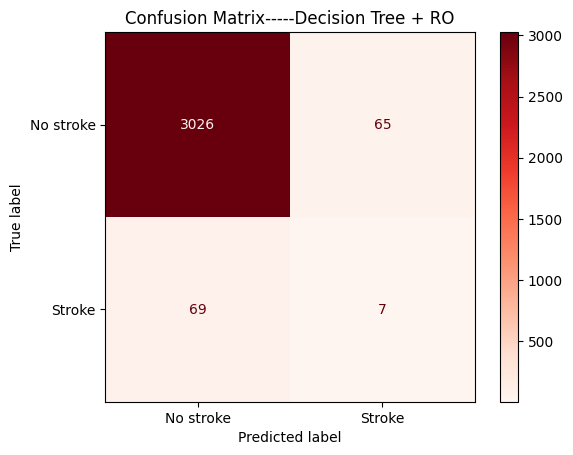

In [401]:
class_names = ['No stroke', 'Stroke']
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay.from_estimator(dtc_best, X_test_ro, y_test, cmap=plot.cm.Reds, display_labels=class_names)
disp.ax_.set_title("Confusion Matrix-----Decision Tree + RO")
plot.show()

Using Decision Tree + SMOTE

Best parameters found: {'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 5, 'min_samples_split': 100}


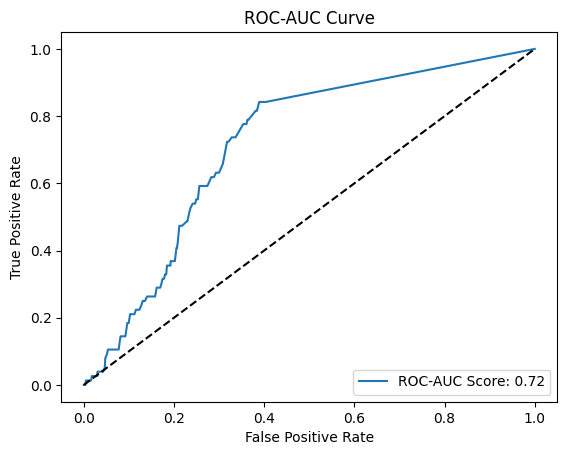

Decision Tree + SMOTE Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.97      0.97      3091
           1       0.02      0.03      0.02        76

    accuracy                           0.95      3167
   macro avg       0.50      0.50      0.50      3167
weighted avg       0.95      0.95      0.95      3167



C:\Users\roysu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.7_qbz5n2kfra8p0\LocalCache\local-packages\Python37\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


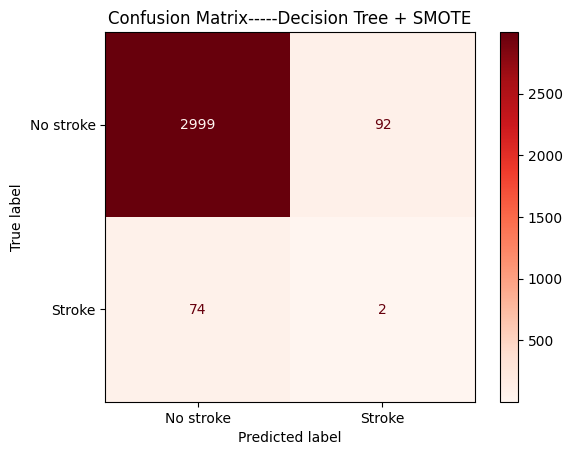

In [402]:
param_grid = {
    "criterion": ["gini", "entropy"],
    "max_depth": [None, 2, 4, 6, 8, 10],
    "min_samples_split": [20, 50, 100],
    "min_samples_leaf": [1, 5]
}

dtc_smote = DecisionTreeClassifier()
grid_search = GridSearchCV(dtc_smote, param_grid, scoring='roc_auc', cv=15)
grid_search.fit(X_train_smote, y_train_smote)

best_params = grid_search.best_params_
print("Best parameters found:", best_params)

dtc_best = DecisionTreeClassifier(**best_params)
dtc_best.fit(X_train_smote, y_train_smote)

y_pred = dtc_best.predict(X_test_smote)
y_pred_proba = dtc_best.predict_proba(X_test_smote)[:, 1]
# Plot ROC-AUC curve
roc_auc = roc_auc_score(y_test, y_pred_proba)
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plot.plot(fpr, tpr, label=f"ROC-AUC Score: {roc_auc:.2f}")
plot.plot([0, 1], [0, 1], 'k--')
plot.xlabel('False Positive Rate')
plot.ylabel('True Positive Rate')
plot.title('ROC-AUC Curve')
plot.legend(loc="lower right")
plot.show()
print("Decision Tree + SMOTE Classification Report:\n", classification_report(y_test, y_pred))
class_names = ['No stroke', 'Stroke']
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay.from_estimator(dtc_best, X_test_smote, y_test, cmap=plot.cm.Reds, display_labels=class_names)
disp.ax_.set_title("Confusion Matrix-----Decision Tree + SMOTE")
plot.show()

In [403]:
roc_auc

0.7179566313065096

# Using XGB

In [423]:
# Create XGBoost classifier
xgb_clf = xgb.XGBClassifier()

# Define hyperparameters to tune
param_grid = {
    "n_estimators": [1000],
    "learning_rate": [0.01, 0.2, 0.3],
    "max_depth":[3]
}

# Create GridSearchCV object
grid_search = GridSearchCV(estimator=xgb_clf, param_grid=param_grid, scoring="f1", cv=5, verbose=1, n_jobs=-1)

# Fit the model
grid_search.fit(X_train_ro, y_train_ro)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     gamma=None, gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_bin=None,
                                     max_ca...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                  

In [424]:
grid_search.best_estimator_


Best learning rate: 0.3


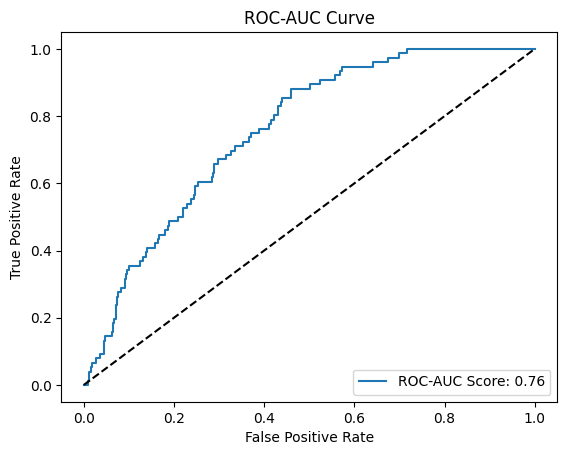

XGB + RO Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.98      0.98      3091
           1       0.07      0.05      0.06        76

    accuracy                           0.96      3167
   macro avg       0.52      0.52      0.52      3167
weighted avg       0.96      0.96      0.96      3167



In [425]:
# Get the best estimator
best_xgb = grid_search.best_estimator_

# Make predictions
y_pred = best_xgb.predict(X_test_ro)
y_pred_proba = best_xgb.predict_proba(X_test_ro)[:, 1]
# Plot ROC-AUC curve
roc_auc = roc_auc_score(y_test, y_pred_proba)
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plot.plot(fpr, tpr, label=f"ROC-AUC Score: {roc_auc:.2f}")
plot.plot([0, 1], [0, 1], 'k--')
plot.xlabel('False Positive Rate')
plot.ylabel('True Positive Rate')
plot.title('ROC-AUC Curve')
plot.legend(loc="lower right")
plot.show()
print("XGB + RO Classification Report:\n", classification_report(y_test, y_pred))

C:\Users\roysu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.7_qbz5n2kfra8p0\LocalCache\local-packages\Python37\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


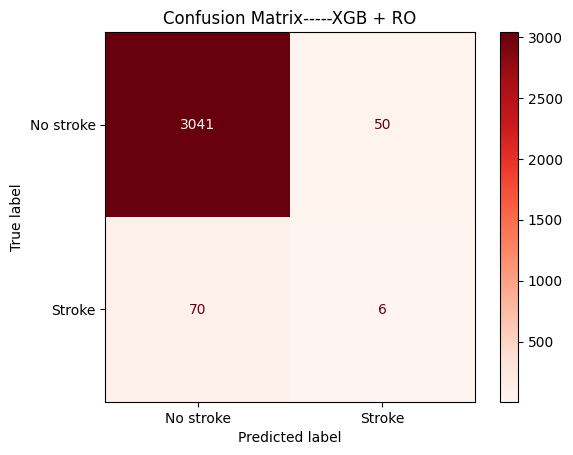

In [414]:
class_names = ['No stroke', 'Stroke']
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay.from_estimator(best_xgb, X_test_ro, y_test, cmap=plot.cm.Reds, display_labels=class_names)
disp.ax_.set_title("Confusion Matrix-----XGB + RO")
plot.show()

Using XGB + SMOTE

Fitting 5 folds for each of 30 candidates, totalling 150 fits


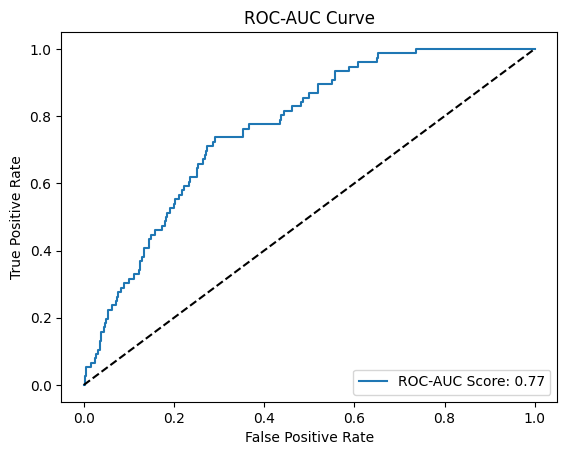

XGB + SMOTE Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.99      0.98      3091
           1       0.14      0.05      0.08        76

    accuracy                           0.97      3167
   macro avg       0.56      0.52      0.53      3167
weighted avg       0.96      0.97      0.96      3167



C:\Users\roysu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.7_qbz5n2kfra8p0\LocalCache\local-packages\Python37\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


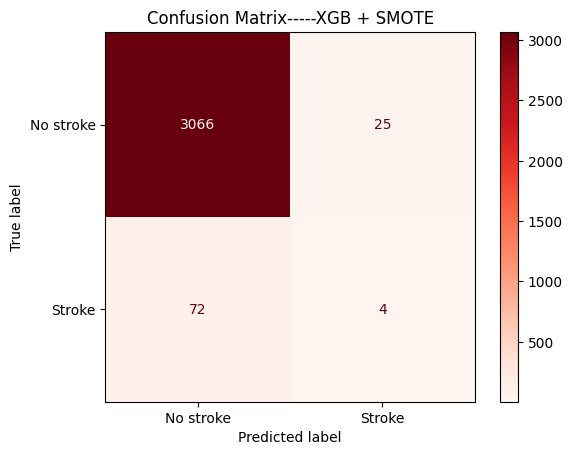

In [426]:
# Create XGBoost classifier
xgb_clf_smote = xgb.XGBClassifier()

# Define hyperparameters to tune
param_grid = {
    "n_estimators": [300, 700],
    "learning_rate": [0.01, 0.2, 0.3],
    "colsample_bytree":[0.2, 0.4, 0.6, 0.9, 1]
}

# Create GridSearchCV object
grid_search = GridSearchCV(estimator=xgb_clf_smote, param_grid=param_grid, scoring="f1", cv=5, verbose=1, n_jobs=-1)

# Fit the model
grid_search.fit(X_train_smote, y_train_smote)

# Get the best estimator
best_xgb = grid_search.best_estimator_

# Make predictions
y_pred = best_xgb.predict(X_test_smote)
y_pred_proba = best_xgb.predict_proba(X_test_smote)[:, 1]
# Plot ROC-AUC curve
roc_auc = roc_auc_score(y_test, y_pred_proba)
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plot.plot(fpr, tpr, label=f"ROC-AUC Score: {roc_auc:.2f}")
plot.plot([0, 1], [0, 1], 'k--')
plot.xlabel('False Positive Rate')
plot.ylabel('True Positive Rate')
plot.title('ROC-AUC Curve')
plot.legend(loc="lower right")
plot.show()
print("XGB + SMOTE Classification Report:\n", classification_report(y_test, y_pred))
class_names = ['No stroke', 'Stroke']
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay.from_estimator(best_xgb, X_test_smote, y_test, cmap=plot.cm.Reds, display_labels=class_names)
disp.ax_.set_title("Confusion Matrix-----XGB + SMOTE")
plot.show()

In [427]:
best_xgb

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.2, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=300,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)